In [1]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split,StratifiedKFold,cross_val_score,cross_validate
from sklearn.metrics import classification_report,make_scorer,confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier
from lightgbm import LGBMClassifier

import seaborn as sns
import matplotlib.pyplot as plt

import os

random_state = 23873


outdir = r'./eval/'
if not os.path.exists(outdir):
    os.mkdir(outdir)
    
outdir = r'./eval/Filters'
if not os.path.exists(outdir):
    os.mkdir(outdir)

In [2]:
dt = pd.read_csv(r'data/refined_data.csv')

In [3]:
from sklearn.model_selection import train_test_split,StratifiedKFold,cross_val_score,cross_validate
from sklearn.metrics import classification_report,make_scorer,confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier
from xgboost import XGBClassifier



import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import classification_report,make_scorer,confusion_matrix


random_state = 23873

def tss(y_true,y_pred,**kwargs):
    tn, fp, fn, tp = confusion_matrix(y_true,y_pred).ravel()
    p = tp + fn 
    n = fp + tn
    tss = (tp/p) - (fp/n)
    return tss

# tss([0, 1, 0, 1], [1, 1, 1, 0])
tss_scorer = make_scorer(tss,greater_is_better=True)

#### hss2

def hss2(y_true,y_pred,**kwargs):
    tn, fp, fn, tp = confusion_matrix(y_true,y_pred).ravel()
    p = tp + fn 
    n = fp + tn
    hss2 = (2 * ((tp*tn) - (fn*fp))) / (p*(fn+tn) + n*(tp+fp))
    return hss2

# hss2([0, 1, 0, 1], [1, 1, 1, 0])
hss2_scorer = make_scorer(hss2,greater_is_better=True)

def modelling_mulitple(x_train, y_train,folder=''):

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    accuracy_means,accuracy_std,precision_means,precision_std,recall_means,recall_std,f1_means,f1_std,tss_mean,tss_std,hss2_mean,hss2_std = [],[],[],[],[],[],[],[],[],[],[],[]

    classifiers = [LogisticRegression(random_state=random_state),DecisionTreeClassifier(random_state=random_state),
                  SVC(random_state=random_state),GaussianNB(),AdaBoostClassifier(random_state=random_state),
                    RandomForestClassifier(n_estimators=20,random_state=random_state),XGBClassifier()
                  ]

    scoring = {'accuracy': 'accuracy',
               'precision_macro': 'precision_macro',
               'recall_macro': 'recall_macro',
               'f1_macro': 'f1_macro',
               'tss': tss_scorer,
               'hss2': hss2_scorer}

    for classifier in classifiers:
        print(classifier)
        scores = cross_validate(classifier, x_train, y_train, scoring=scoring, cv=cv)
        accuracy_means.append(scores['test_accuracy'].mean())
        precision_means.append(scores['test_precision_macro'].mean())
        precision_std.append(scores['test_precision_macro'].std())
        recall_means.append(scores['test_recall_macro'].mean())
        recall_std.append(scores['test_recall_macro'].std())
        f1_means.append(scores['test_f1_macro'].mean())
        f1_std.append(scores['test_f1_macro'].std())
        tss_mean.append(scores['test_tss'].mean())
        tss_std.append(scores['test_tss'].std())
        hss2_mean.append(scores['test_hss2'].mean())
        hss2_std.append(scores['test_hss2'].std())

    cv_res = pd.DataFrame(data={'Algorithms':['LogisticRegression','DecisionTree','SVM','Naive Bayes','AdaBoost',
                                              'RandomForest','XGBoost'],'Accuracy Mean Score':accuracy_means,
                                                'Precision Mean Score':precision_means, 'Precision std':precision_std,
                                                'Recall Mean Score':recall_means, 'Recall std':recall_std,'F1 Mean Score':f1_means, 'F1 std':f1_std,
                                                'TSS Mean Score':tss_mean, 'TSS std':tss_std, 'HSS2 Mean Score':hss2_mean, 'HSS2 std':hss2_std
                               })

    f, axes = plt.subplots(2, 3, figsize=(20, 12))
    axes = axes.flatten()
    

    sns.barplot(x = 'Accuracy Mean Score',y = 'Algorithms',data = cv_res, palette = "Set2",ax=axes[0]).set(title='Cross Validation Scores')
    sns.barplot(x = 'Precision Mean Score',y = 'Algorithms',data = cv_res, palette = "Set2",ax=axes[1]).set(title='Cross Validation Scores')
    sns.barplot(x = 'Recall Mean Score',y = 'Algorithms',data = cv_res, palette = "Set2",ax=axes[2]).set(title='Cross Validation Scores')
    sns.barplot(x = 'F1 Mean Score',y = 'Algorithms',data = cv_res, palette = "Set2",ax=axes[3]).set(title='Cross Validation Scores')
    sns.barplot(x = 'TSS Mean Score',y = 'Algorithms',data = cv_res, palette = "Set2",ax=axes[4]).set(title='Cross Validation Scores')
    sns.barplot(x = 'HSS2 Mean Score',y = 'Algorithms',data = cv_res, palette = "Set2",ax=axes[5]).set(title='Cross Validation Scores')

    accc = ['Accuracy Mean Score', 'Precision Mean Score', 'Recall Mean Score', 'F1 Mean Score', 'TSS Mean Score', 'HSS2 Mean Score']

    for i, acc in enumerate(accc):
        fig, ax = plt.subplots(figsize=(10, 6))
        sns.barplot(x=acc, y='Algorithms', data=cv_res, palette="Set2", ax=ax).set(title='Cross Validation Scores')

        # Adjust the spacing between subplots
        plt.tight_layout()

        # Save each figure with a different name
        fig.savefig(os.path.join(outdir, f'{acc}_{folder}.png'), dpi=300, bbox_inches='tight')
        plt.close(fig)  # Close the figure
    
    return cv_res.sort_values(by='Accuracy Mean Score', ascending=False)

### Pearson Correlation

In [4]:
def cor_selector(X, y):
    cor_list = []
    feature_name = X.columns.tolist()
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-10:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature

In [5]:
features = dt.copy()
target = features.pop('Label')
cor_support, cor_feature = cor_selector(features, target)
print(str(len(cor_feature)), 'selected features')
selected_cols = cor_feature

10 selected features


In [6]:
from lazypredict.Supervised import LazyClassifier
features = dt[cor_feature + ['Label']].copy()
target = features.pop('Label')
x_train, x_test, y_train, y_test = train_test_split(StandardScaler().fit_transform(features), target,stratify=target, test_size=0.3,random_state=random_state)
clf=LazyClassifier(verbose=0,ignore_warnings=True,custom_metric=None)
models_filter_corr,predictions=clf.fit(x_train, x_test, y_train, y_test)

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:01<00:00, 26.91it/s]


In [7]:
models_filter_corr.to_csv(os.path.join(outdir, 'model_eval_corr.csv'))

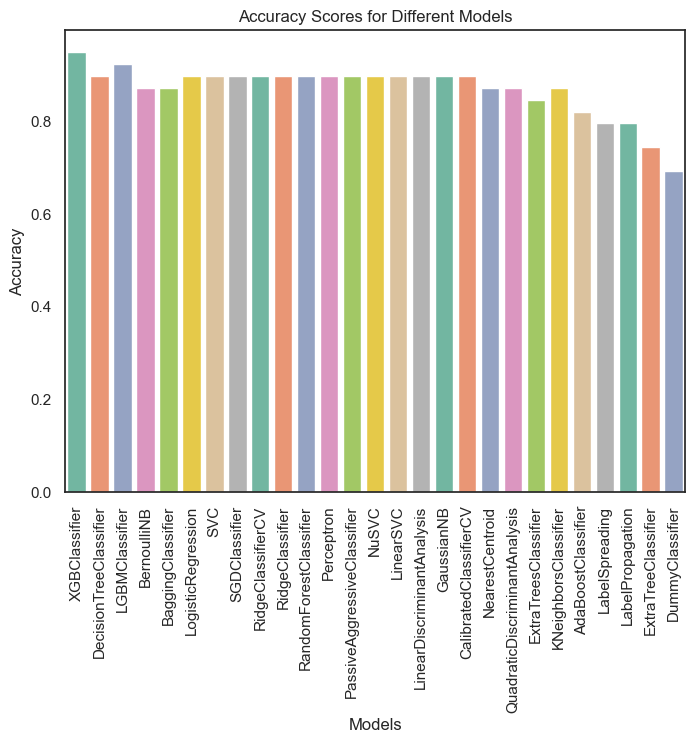

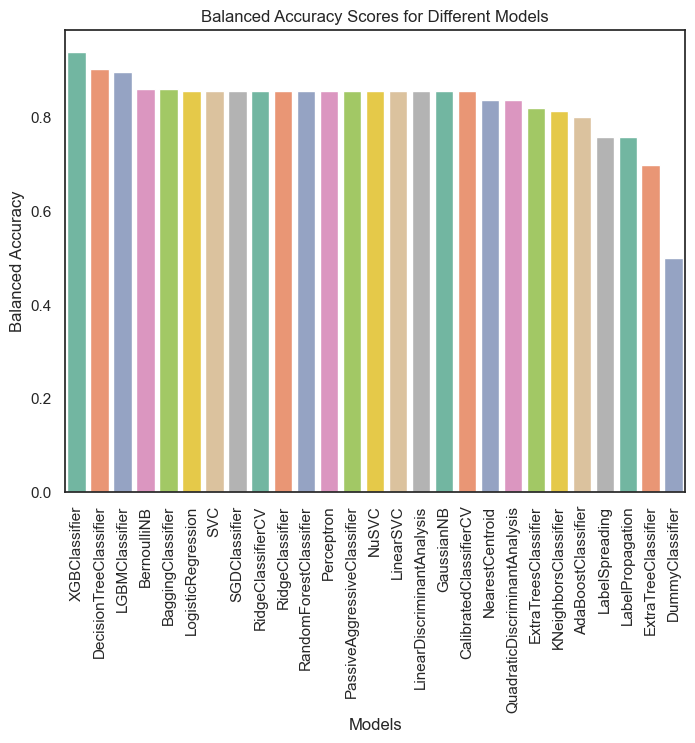

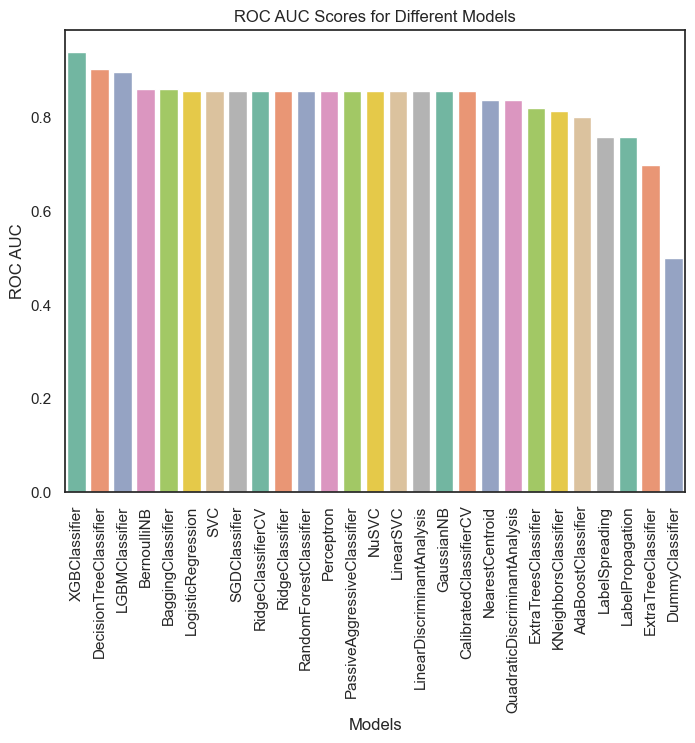

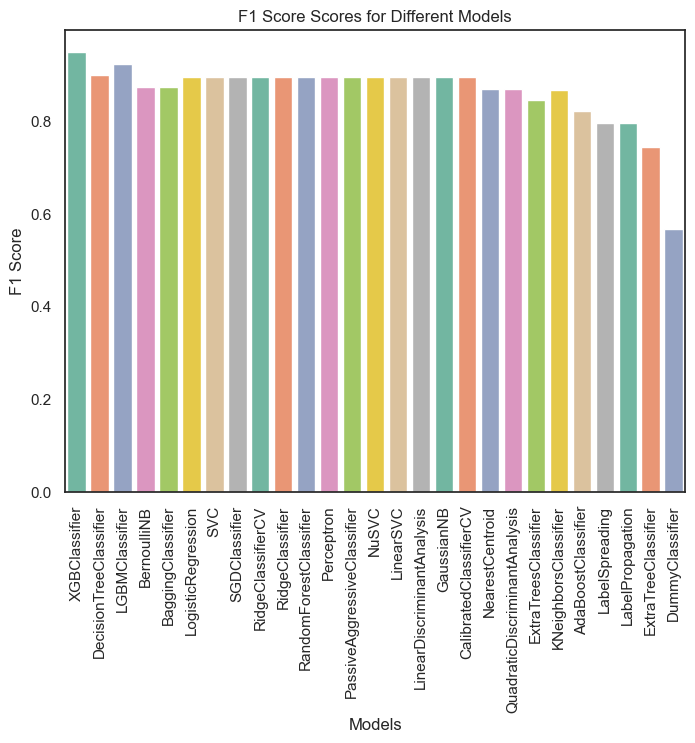

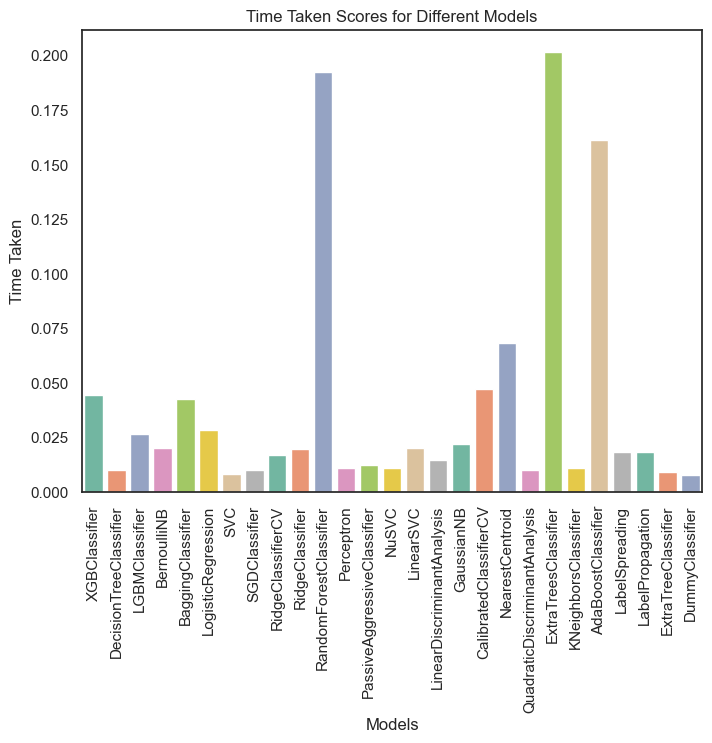

In [8]:
for x in models_filter_corr.columns:
    plt.figure(figsize=(8, 6))
    sns.set(style="white")
    sns.barplot(x=models_filter_corr.index, y=x, data=models_filter_corr,  palette="Set2")
    plt.title(f'{x} Scores for Different Models')
    plt.xticks(rotation=90)
    plt.xlabel('Models')
    plt.ylabel(x)
    plt.savefig(os.path.join(outdir, f'Correlation_Results_based_on_{x}.png'), dpi=300, bbox_inches='tight')
    plt.show()

In [9]:
with open(os.path.join(outdir,'selected features_correlation.txt'), 'w') as file:
    file.writelines('\n'.join(selected_cols))

LogisticRegression(random_state=23873)
DecisionTreeClassifier(random_state=23873)
SVC(random_state=23873)
GaussianNB()
AdaBoostClassifier(random_state=23873)
RandomForestClassifier(n_estimators=20, random_state=23873)
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)


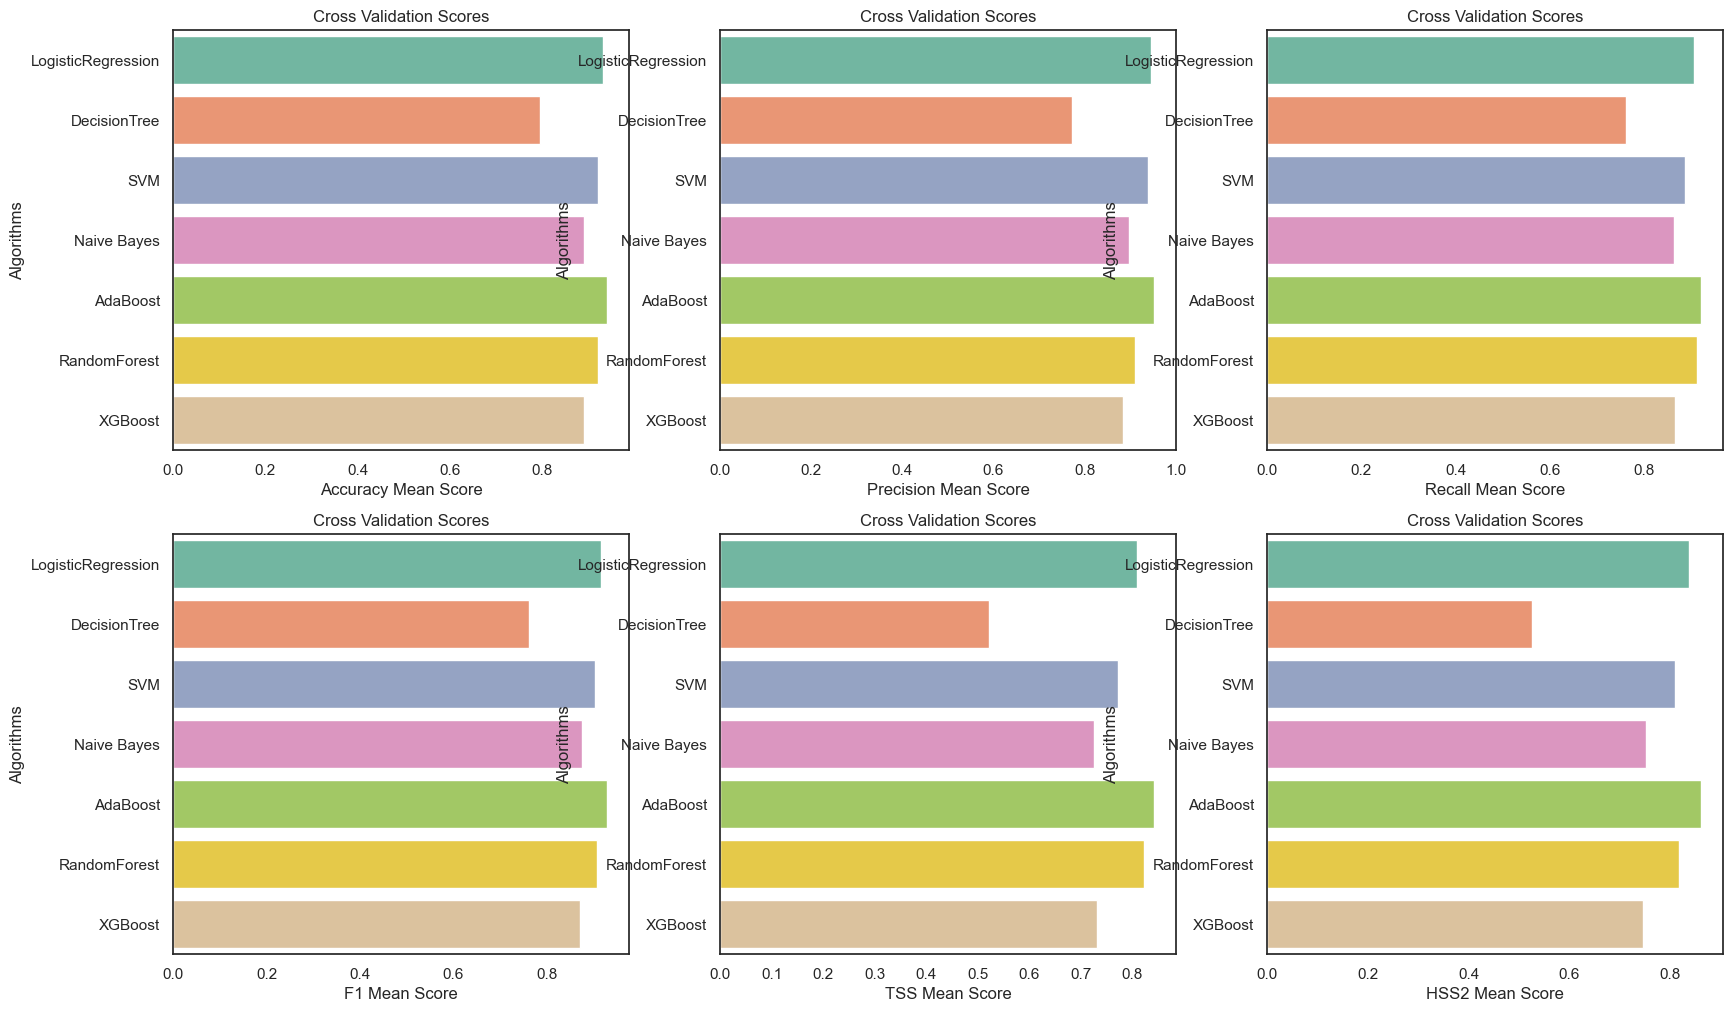

In [10]:
features = dt[selected_cols + ['Label']].copy()
target = features.pop('Label')
features = StandardScaler().fit_transform(features)
x_train, x_test, y_train, y_test = train_test_split(features, target,stratify=target, test_size=0.2)

modelling_mulitple(x_train, y_train, 'corr_manual').to_csv(os.path.join(outdir, 'model_eval_manual_corr.csv'), index=False)

### Information Gain

In [11]:
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
features = dt.copy()
target = features.pop('Label')
X_norm = MinMaxScaler().fit_transform(features)
features[features.columns] = X_norm
importances = mutual_info_classif(features,target)
feat_importances = pd.Series(importances,features.columns[0:len(features.columns)])

In [13]:
# top 10 informative features
selected_cols = feat_importances.sort_values(axis=0, ascending=False, inplace=False)[0:10].index.to_list()
with open(os.path.join(outdir,'selected features_information_gain.txt'), 'w') as file:
    file.writelines('\n'.join(selected_cols))

features = dt[feat_importances.sort_values(axis=0, ascending=False, inplace=False)[0:10].index.to_list()
 + ['Label']].copy()
target = features.pop('Label')
x_train, x_test, y_train, y_test = train_test_split(StandardScaler().fit_transform(features), target,stratify=target, test_size=0.3,random_state=random_state)
clf=LazyClassifier(verbose=0,ignore_warnings=True,custom_metric=None)
models_ig,predictions=clf.fit(x_train, x_test, y_train, y_test)

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 30.94it/s]


In [14]:
models_ig.to_csv(os.path.join(outdir, 'model_eval_information_gain.csv'))

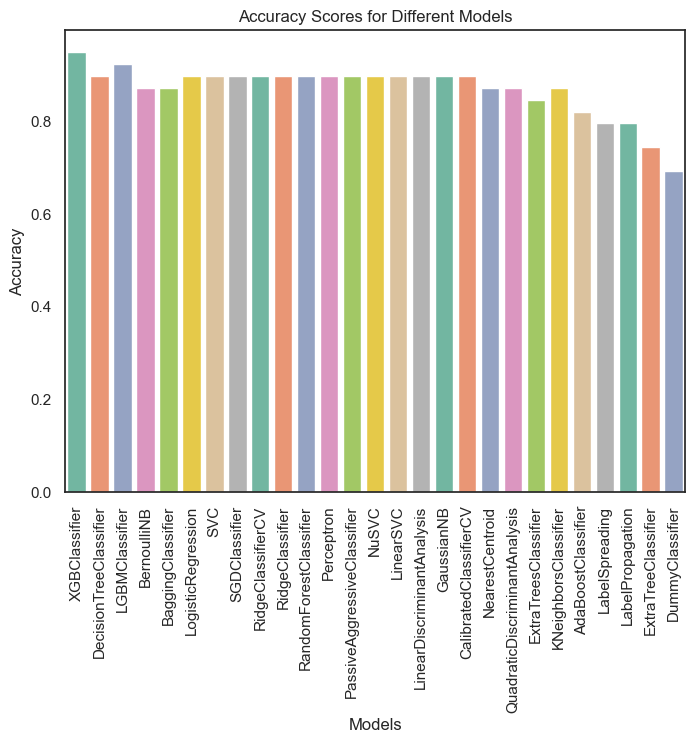

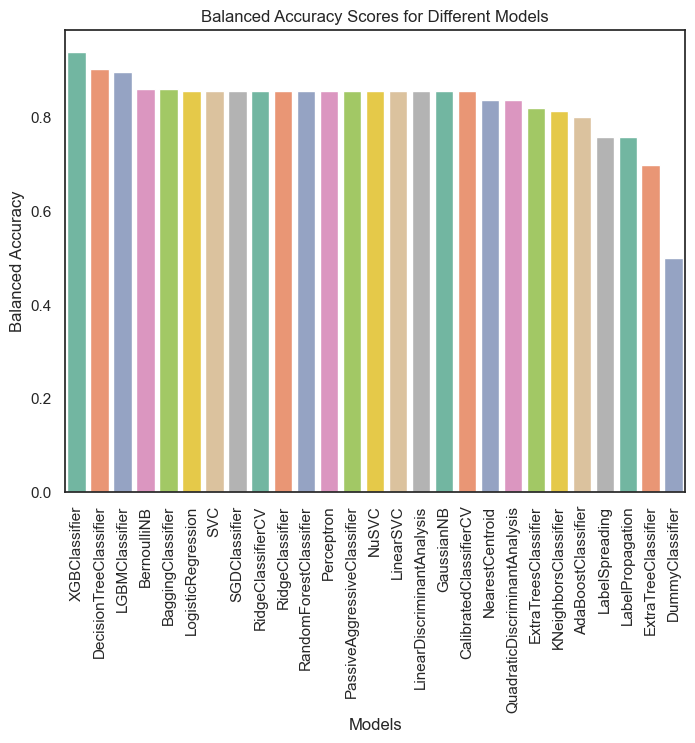

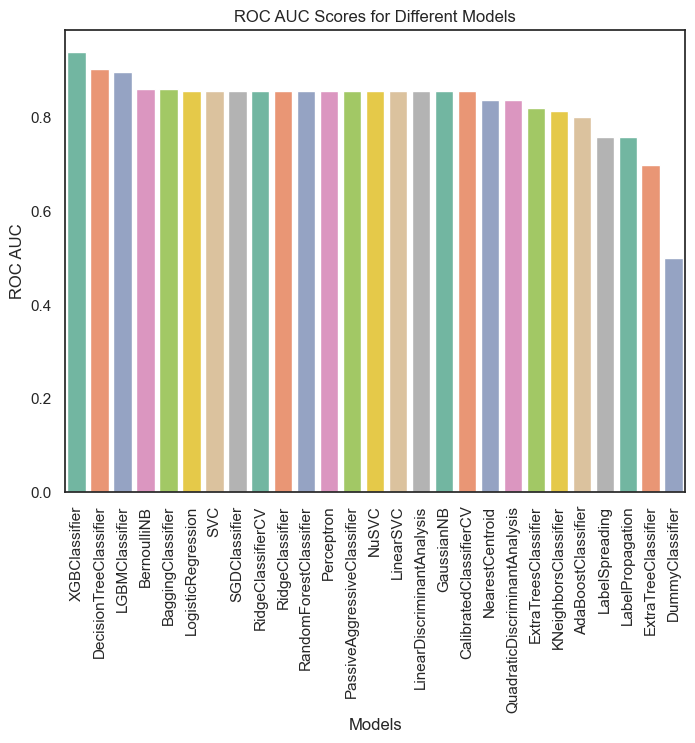

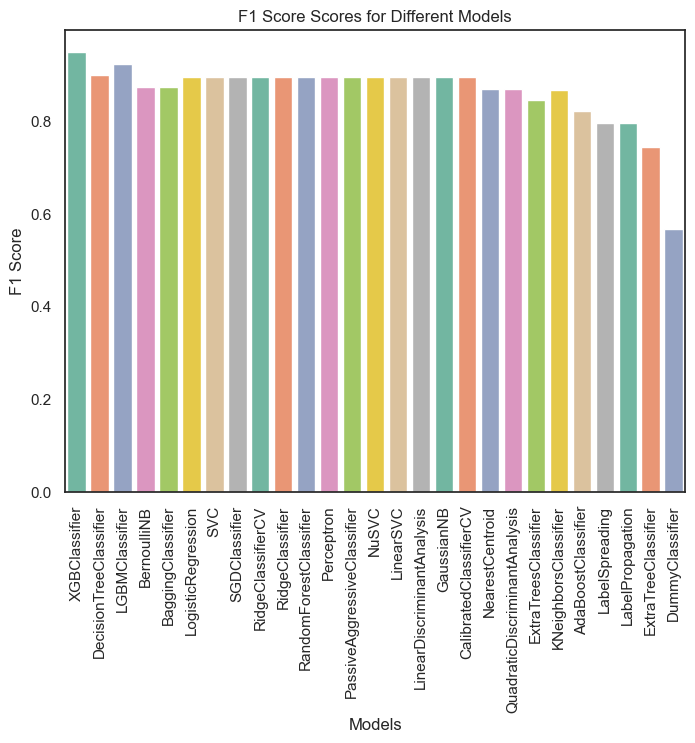

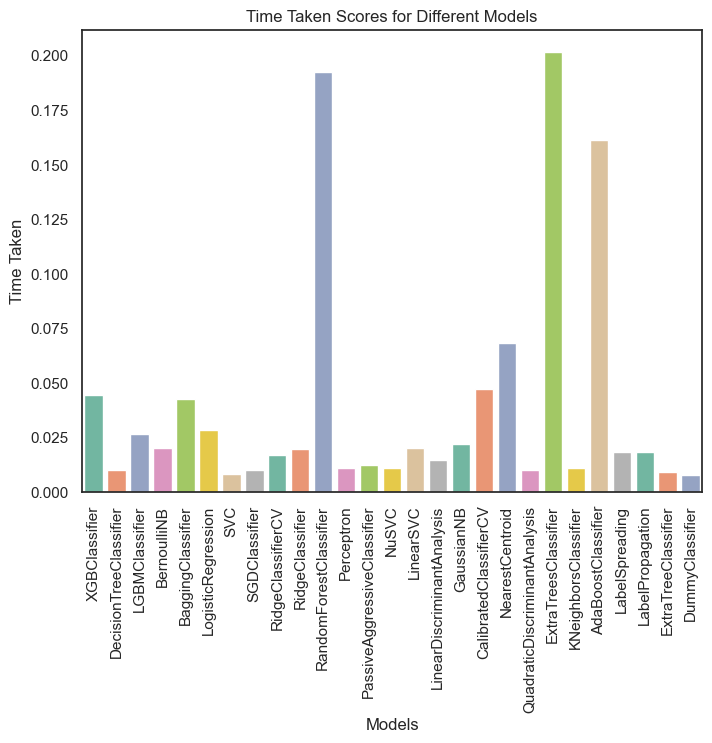

In [15]:
for x in models_ig.columns:
    plt.figure(figsize=(8, 6))
    sns.set(style="white")
    sns.barplot(x=models_filter_corr.index, y=x, data=models_filter_corr,  palette="Set2")
    plt.title(f'{x} Scores for Different Models')
    plt.xticks(rotation=90)
    plt.xlabel('Models')
    plt.ylabel(x)
    plt.savefig(os.path.join(outdir, f'Information_Gain_Results_based_on_{x}.png'), dpi=300, bbox_inches='tight')
    plt.show()

In [16]:
with open(os.path.join(outdir,'selected features_ig.txt'), 'w') as file:
    file.writelines('\n'.join(selected_cols))

LogisticRegression(random_state=23873)
DecisionTreeClassifier(random_state=23873)
SVC(random_state=23873)
GaussianNB()
AdaBoostClassifier(random_state=23873)
RandomForestClassifier(n_estimators=20, random_state=23873)
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)


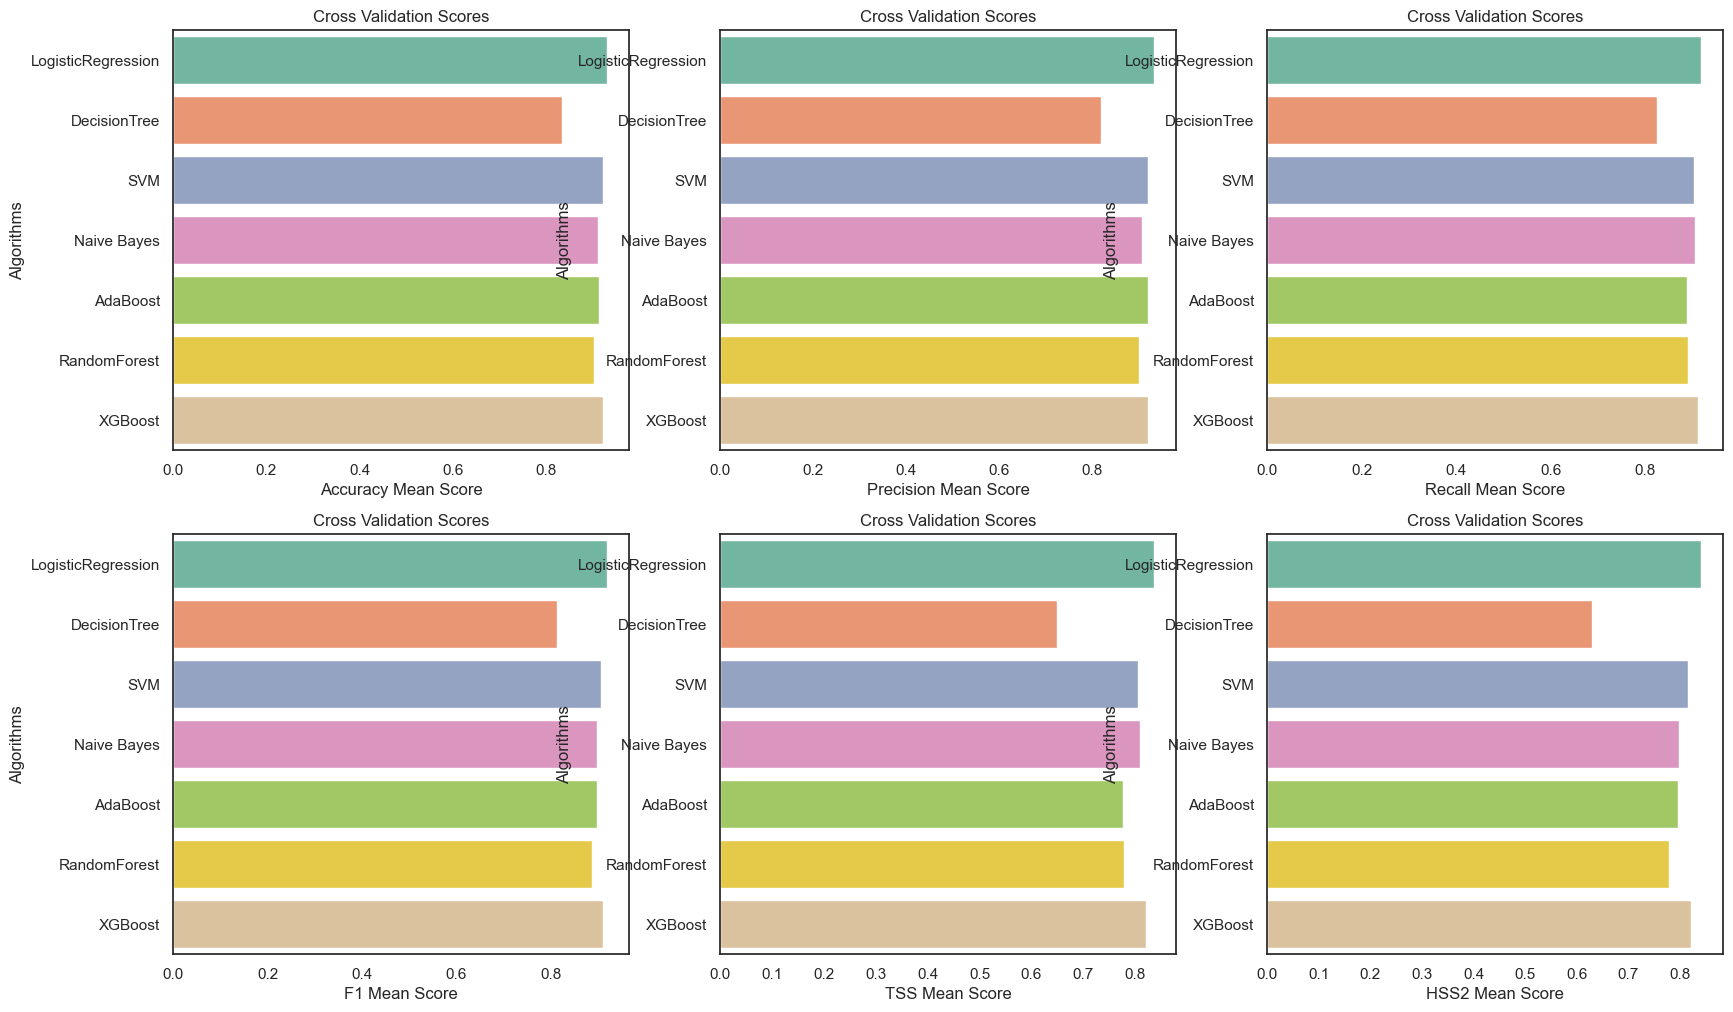

In [17]:
features = dt[selected_cols+ ['Label']].copy()
target = features.pop('Label')
features = StandardScaler().fit_transform(features)
x_train, x_test, y_train, y_test = train_test_split(features, target,stratify=target, test_size=0.2)

modelling_mulitple(x_train, y_train,'ig_manual').to_csv(os.path.join(outdir, 'model_eval_manual_ig.csv'), index=False)

### Difference

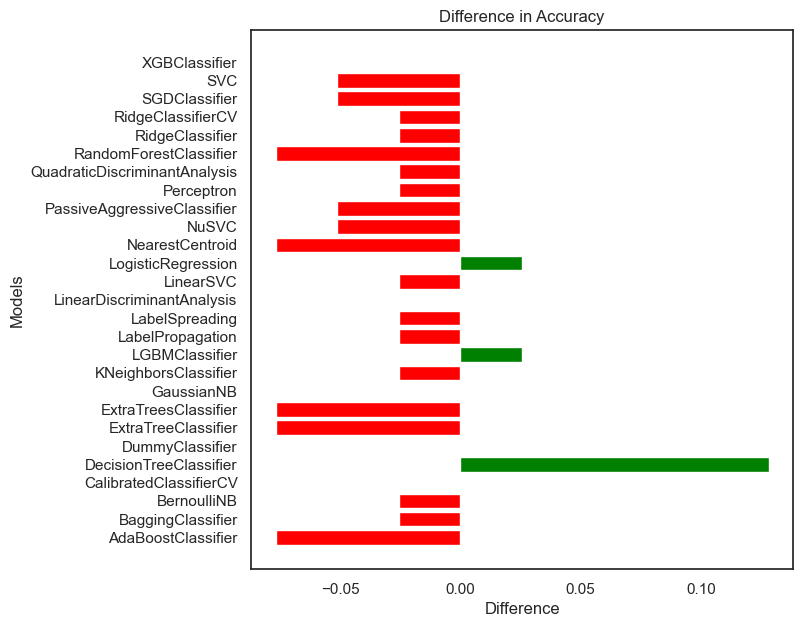

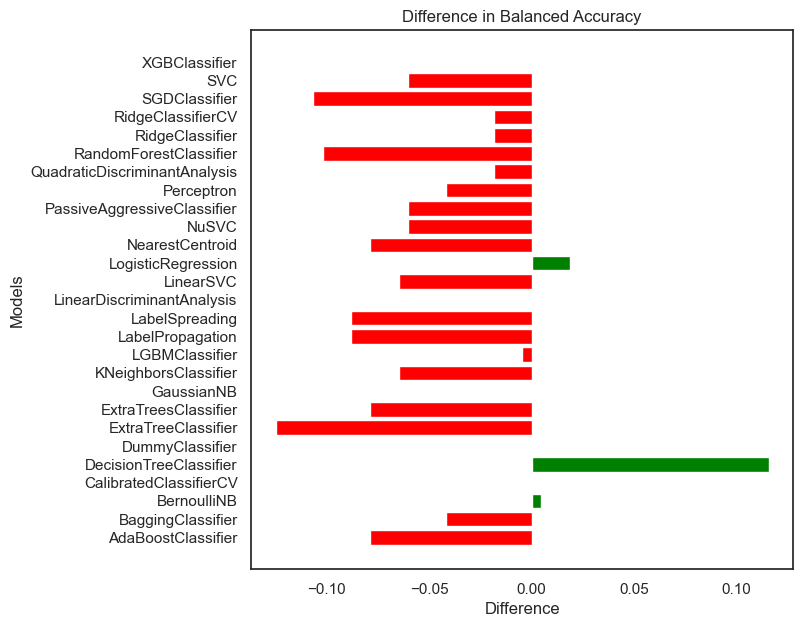

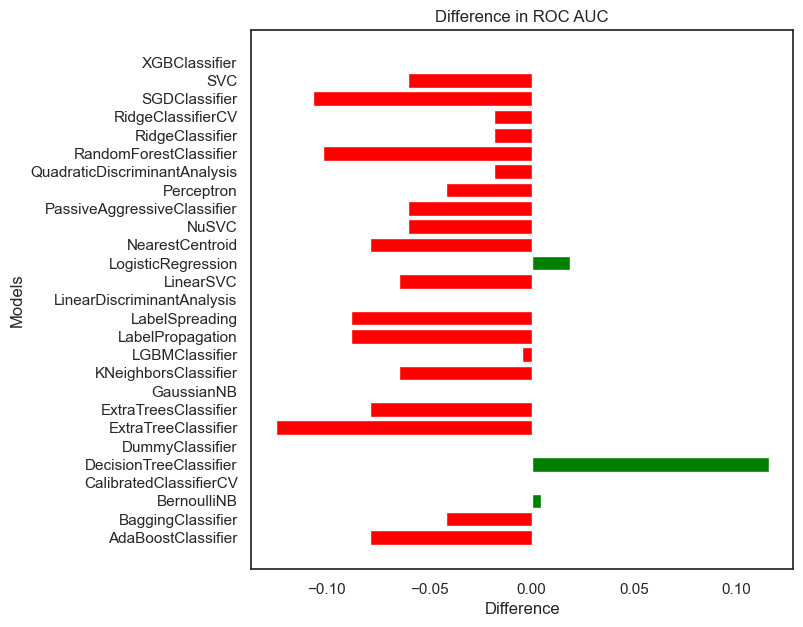

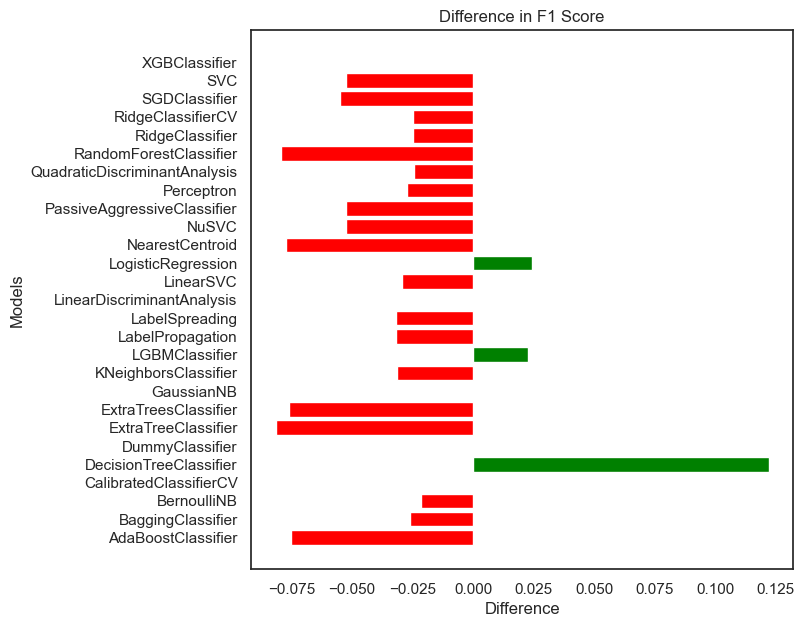

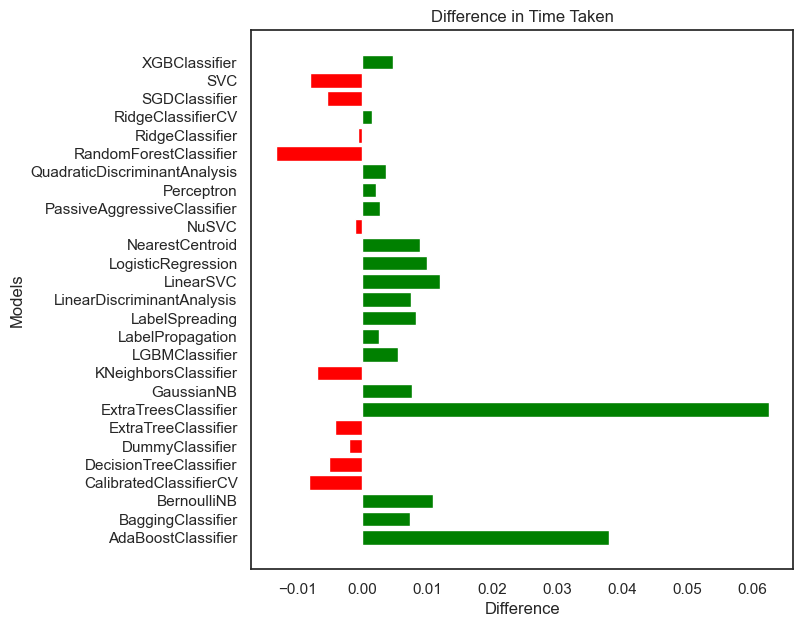

In [18]:
#Difference between both methods (correlation & Information Gain)
for x in models_ig.columns:
    # Calculate the difference between the two dataframes
    diff = models_filter_corr.sort_index()[x] - models_ig.sort_index()[x]

    # Set the color map
    colors = ['red' if d < 0 else 'green' for d in diff]

    # Create the horizontal bar plot
    plt.figure(figsize=(7, 7))
    plt.barh(models_ig.sort_index().index, diff, color=colors)

    # Add labels and title
    plt.xlabel('Difference')
    plt.ylabel('Models')
    plt.title(f'Difference in {x}')
    plt.savefig(os.path.join(outdir, f"ig_corr_{'_'.join(x.split(' '))}_diff.png"), dpi=300, bbox_inches='tight')

    # Show plot
    plt.show()

In [19]:
from lazypredict.Supervised import LazyClassifier
features = dt.copy()
target = features.pop('Label')
x_train, x_test, y_train, y_test = train_test_split(features, target,stratify=target, test_size=0.3,random_state=random_state)
clf=LazyClassifier(verbose=0,ignore_warnings=True,custom_metric=None)
models,predictions=clf.fit(x_train, x_test, y_train, y_test)

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [01:06<00:00,  2.29s/it]


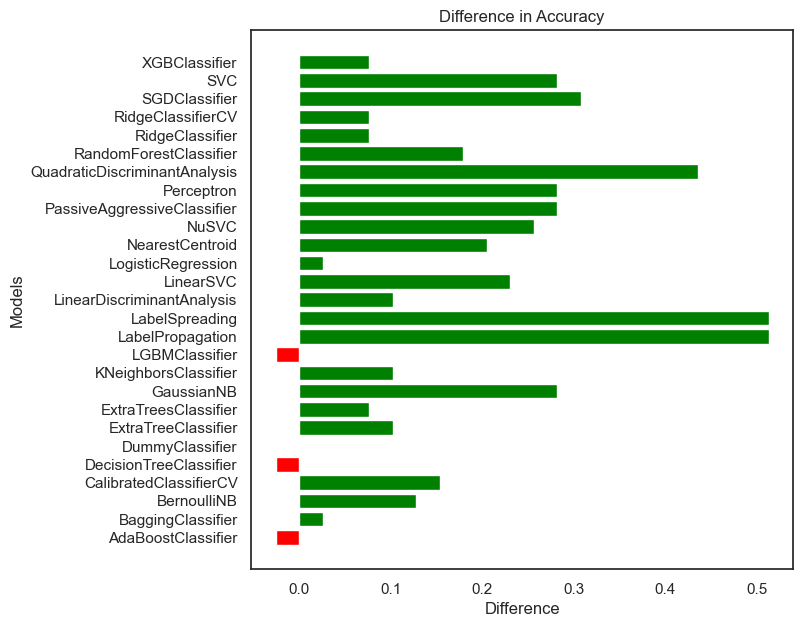

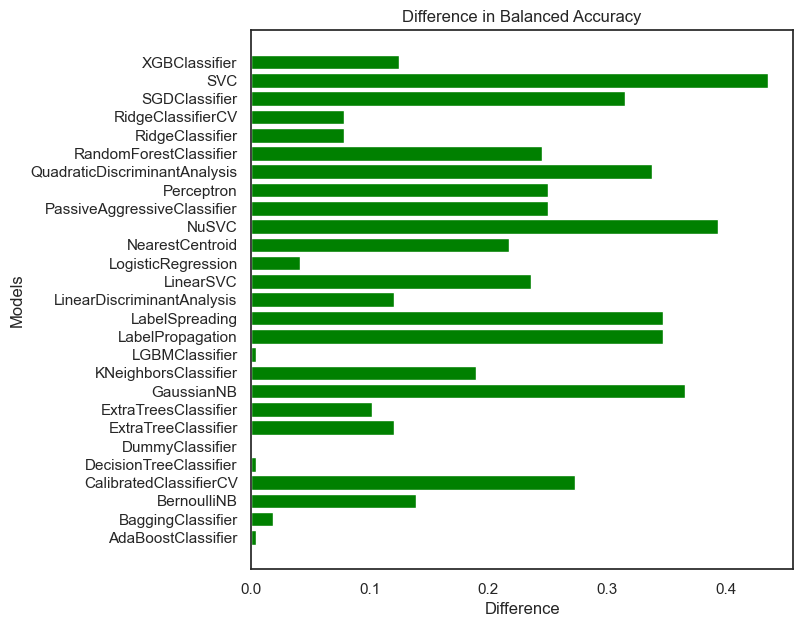

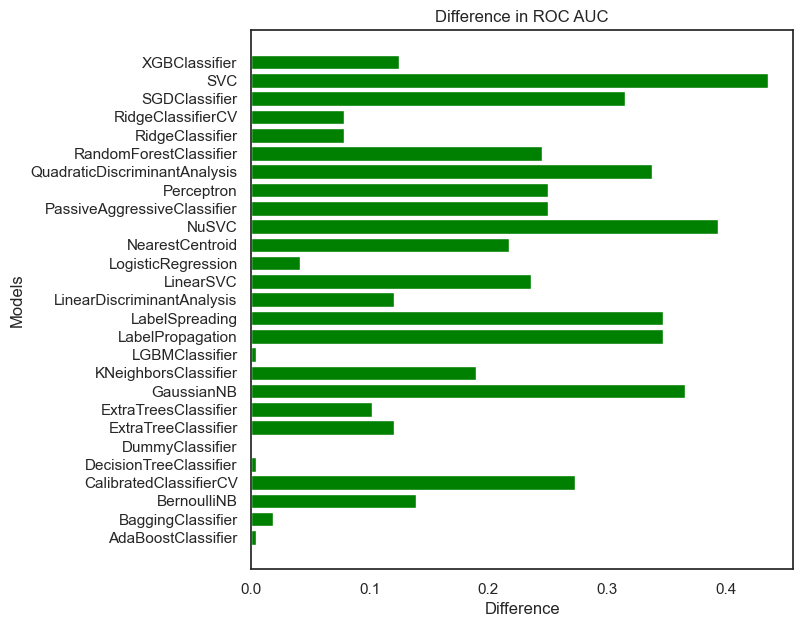

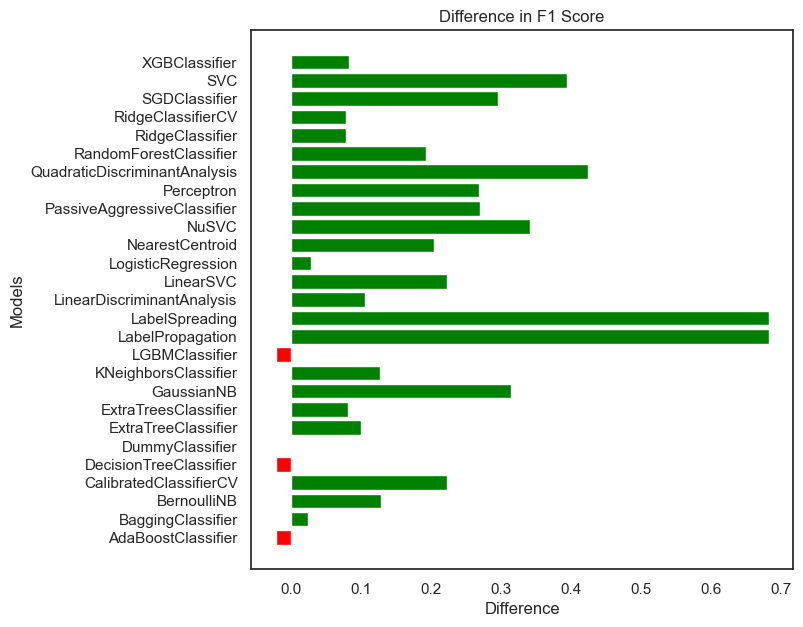

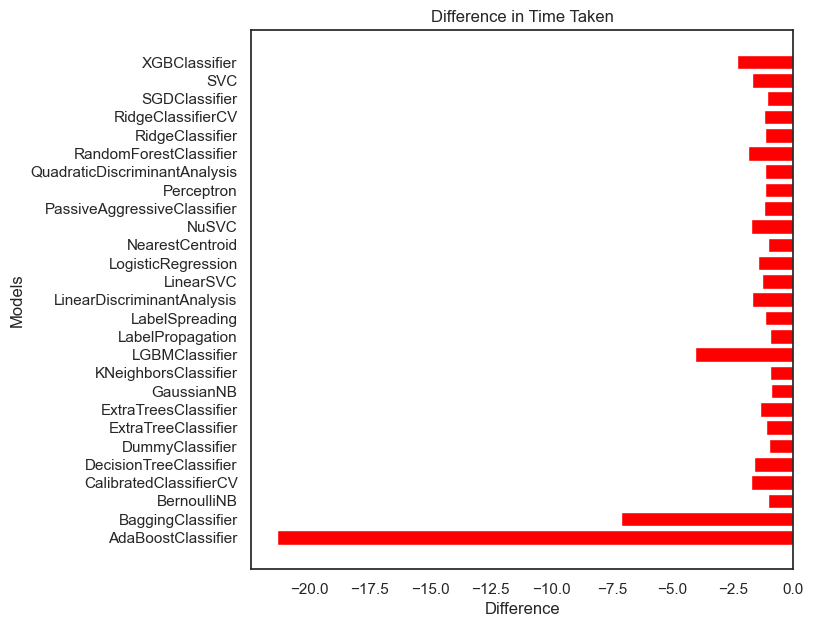

In [20]:
#Difference between both methods (correlation & Information Gain)
for x in models.columns:
    # Calculate the difference between the two dataframes
    diff = models_ig.sort_index()[x] - models.sort_index()[x]

    # Set the color map
    colors = ['red' if d < 0 else 'green' for d in diff]

    # Create the horizontal bar plot
    plt.figure(figsize=(7, 7))
    plt.barh(models.sort_index().index, diff, color=colors)

    # Add labels and title
    plt.xlabel('Difference')
    plt.ylabel('Models')
    plt.title(f'Difference in {x}')
    plt.savefig(os.path.join(outdir, f"baseline_ig_{'_'.join(x.split(' '))}_diff.png"), dpi=300, bbox_inches='tight')

    # Show plot
    plt.show()

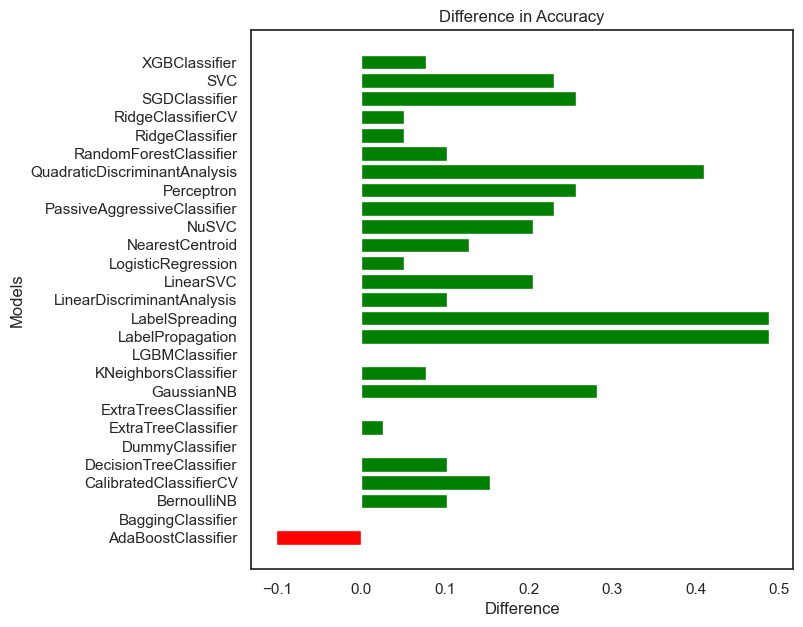

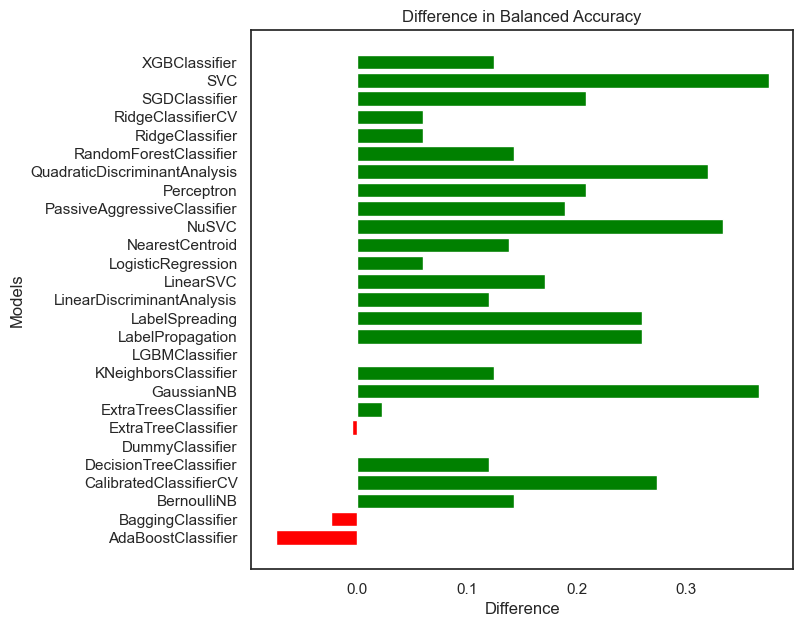

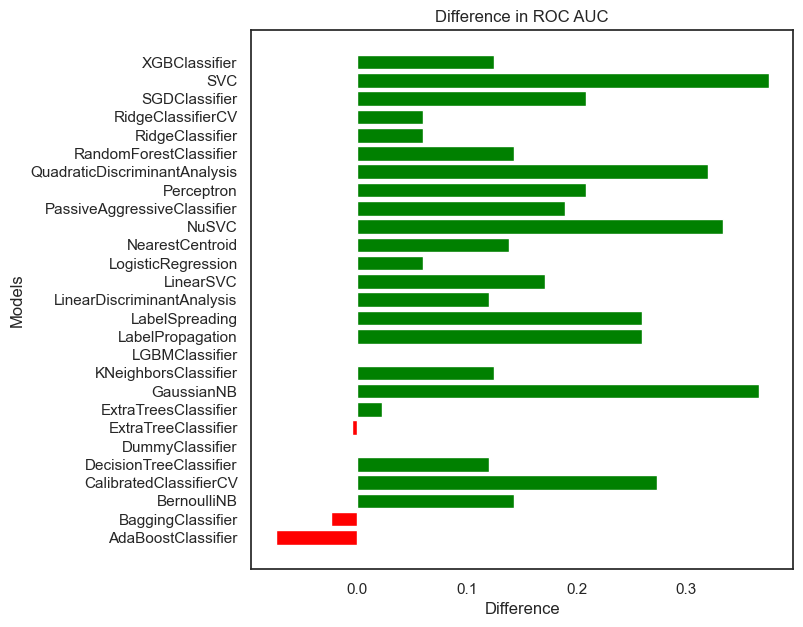

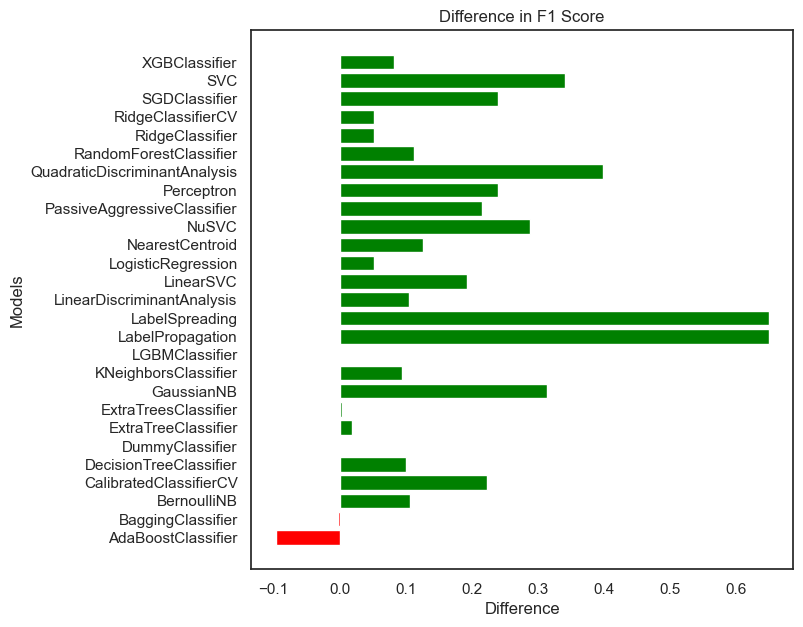

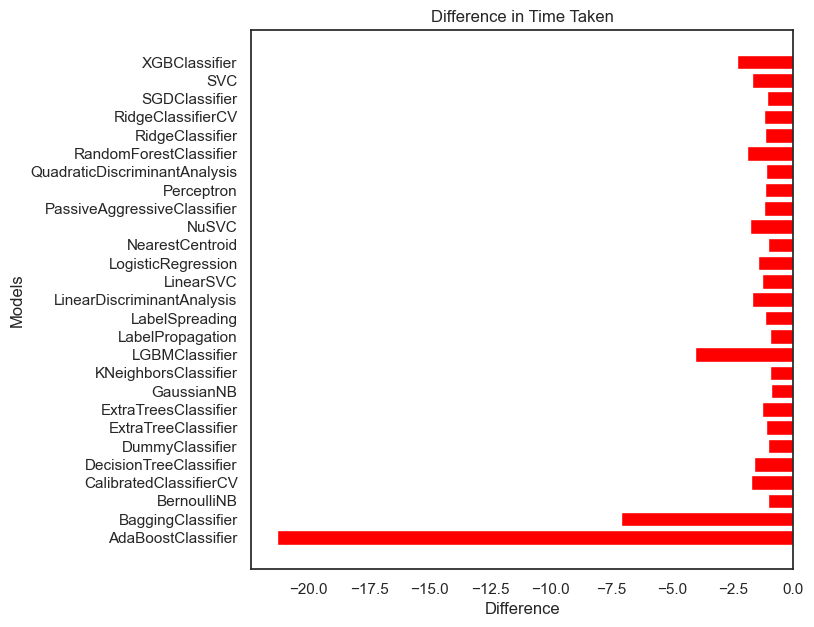

In [21]:
#Difference between both methods (correlation & Information Gain)
for x in models.columns:
    # Calculate the difference between the two dataframes
    diff = models_filter_corr.sort_index()[x] - models.sort_index()[x]

    # Set the color map
    colors = ['red' if d < 0 else 'green' for d in diff]

    # Create the horizontal bar plot
    plt.figure(figsize=(7, 7))
    plt.barh(models.sort_index().index, diff, color=colors)

    # Add labels and title
    plt.xlabel('Difference')
    plt.ylabel('Models')
    plt.title(f'Difference in {x}')
    plt.savefig(os.path.join(outdir, f"baseline_corr_{'_'.join(x.split(' '))}_diff.png"), dpi=300, bbox_inches='tight')

    # Show plot
    plt.show()